In [1]:
NAME = "Matthew A. Hernandez"
# University of Arizona email address
EMAIL = "mah8@arizona.edu"

## Class Competition
Description, Evaluation, and Data Set taken from the [class competition site](https://www.kaggle.com/competitions/ling-539-sp-2024-class-competition) and [GitHub blog](https://uazhlt-ms-program.github.io/ling-539-course-blog/assignments/class-competition).

## Description
Marvin works at the last Blockbusta Videoz (a fictional video rental shop) where his task is to classify movie and TV show reviews to help curate a special section of the store.

One day while perusing his favorite website, Marvin came upon a post about someone who secretly automated their job and then quietly took off on a long (paid) vacation. Inspired, Marvin set aside a portion of his salary to hire a developer to write a few scripts to scrape movie reviews from various sources. It's a bit noisy, but aggregating many reviews has cut the time he previously spent on his job by half.

Now, after reading an article about AI, Marvin wants to take things a step further: he is searching for a program that can determine a) whether or not a piece of text is a movie/TV show review and b) whether or not each review is positive (the movie/TV show is recommended) or negative (the movie/TV show should be avoided).

Marvin has put together a competition and advertised it on Fraggle (a fictional platform for competitive data science).

## Evaluation

The evaluation metric for this competition is the macro F1 score (i.e., the unweighted mean F1). The F1 score, commonly used in information retrieval, measures accuracy using the statistics precision *P* and recall *R*.

Precision is the ratio of true positives *TP* to all the predicted positions *TP+FP*. Recall is the ratio of true positives *TP* to all the actual positives *TP+FN*. The F1 score is given by:


$$
F1 = 2\frac{P*R}{P+R}, Precision = \frac{TP}{TP+FP}, Recall = \frac{TP}{TP+FN}
$$


The F1 metric weighs recall and precision equally. Moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

## Data Set

| **FILE NAME**         | **AVAILABLE FORMATS**       | 
|-----------------------|-----------------------------|
|  train                | .csv (64.9 MB)              | 
|  test                 | .csv (15.9 MB)              |
|  sample_submission    | .csv (?? kb)                |


| **COLUMN** | **DESCRIPTION**                         | 
|------------|-----------------------------------------| 
|  ID        | Unique ID for this datapoint            |
|  TEXT      | The text of the document                | 
|  LABEL     | The label for the datapoint (see below) |

| **LABEL** | **DESCRIPTION**                       | 
|-----------|---------------------------------------|
|  0        | Not a movie or TV show review         | 
|  1        | A positive movie or TV show review    |
|  2        | A negative movie or TV show review    |

## 1. Setup and Imports

In [2]:
# Utilities
import pandas as pd
import numpy as np
import pickle
import re
# Plotting
import matplotlib.pyplot as plt
# NLTK Modules
import nltk
from nltk import word_tokenize, sent_tokenize
# from nltk import WordNetLemmatizer
# from nltk.corpus import wordnet as wn
# from nltk.corpus import sentiwordnet as swn

import time

from scipy.sparse import csr_matrix
from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# Paths
train_file_path = "../data/train.csv"
test_file_path = "../data/test.csv"

## 2. Explore the data

In [3]:
def read_reviews(reviews_path):
    '''
    Reads a CSV file and returns a dataframe.
    
    @param reviews_path:
    @return: pd.DataFrame
    '''
    df = pd.read_csv(reviews_path)
    return df

df_train = read_reviews(train_file_path)
df_test = read_reviews(test_file_path)
df_train.head()

,ID,TEXT,LABEL
0,7850790573542594519,If you love good films don't ever buy this pei...,2
1,9392069522632994700,The 33 percent of the nations nitwits that sti...,2
2,5083704536542443514,I saw Anatomy years ago -- dubbed at a friends...,1
3,12418349755186772171,Dark Remains is a home run plain and simple. T...,1
4,12144957944004619479,Feh. This movie started out in an interesting ...,2


In [4]:
print(f"Dataframe shape: {df_train.shape[0]}")
print(f"Dataframe types: \n{df_train.dtypes}")

Dataframe shape: 70317
Dataframe types: 
ID       uint64
TEXT     object
LABEL     int64
dtype: object


### Dropping unhelpful rows

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70317 entries, 0 to 70316
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70317 non-null  uint64
 1   TEXT    70311 non-null  object
 2   LABEL   70317 non-null  int64 
dtypes: int64(1), object(1), uint64(1)
memory usage: 1.6+ MB


Text column is missing 6 values. The shape of the dataframe is 70317. The data set is relatively clean, so no additional preprocessing is needed.

In [6]:
# df_train['TEXT'].dropna(value='Zero', inplace=True)

In [7]:
df_train = df_train.dropna()

**Drop missing values.** Other option would be to replace the Text columns with an 'Unknown' value.

In [8]:
# verify the changes were made
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70311 entries, 0 to 70316
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70311 non-null  uint64
 1   TEXT    70311 non-null  object
 2   LABEL   70311 non-null  int64 
dtypes: int64(1), object(1), uint64(1)
memory usage: 2.1+ MB


In [9]:
df_train.describe()

,ID,LABEL
count,7.031100e+04,70311.000000
mean,9.236909e+18,0.813756
std,5.341532e+18,0.831366
min,5.764730e+14,0.000000
25%,4.592502e+18,0.000000
50%,9.272107e+18,1.000000
75%,1.387516e+19,2.000000
max,1.844662e+19,2.000000


In [10]:
df_test.head()

,ID,TEXT
0,4728459160322025755,An excellent debut movie for the the director ...
1,1840432070229003467,If you have a preschooler or remember how stre...
2,12623336783082722606,What should have been a routine babysitting gi...
3,7446733850828603409,Cute but
4,16180660281866613068,"Elvis Presley plays a ""half-breed"" Native Amer..."


In [11]:
print(f"Dataframe shape: {df_test.shape[0]}")
print(f"Dataframe types: \n{df_test.dtypes}")

Dataframe shape: 17580
Dataframe types: 
ID      uint64
TEXT    object
dtype: object


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17580 entries, 0 to 17579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      17580 non-null  uint64
 1   TEXT    17579 non-null  object
dtypes: object(1), uint64(1)
memory usage: 274.8+ KB


In [13]:
df_test['TEXT'].fillna(value='Unknown', inplace=True)

In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17580 entries, 0 to 17579
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      17580 non-null  uint64
 1   TEXT    17580 non-null  object
dtypes: object(1), uint64(1)
memory usage: 274.8+ KB


### 2.1 Let's take a look at our data distribution:

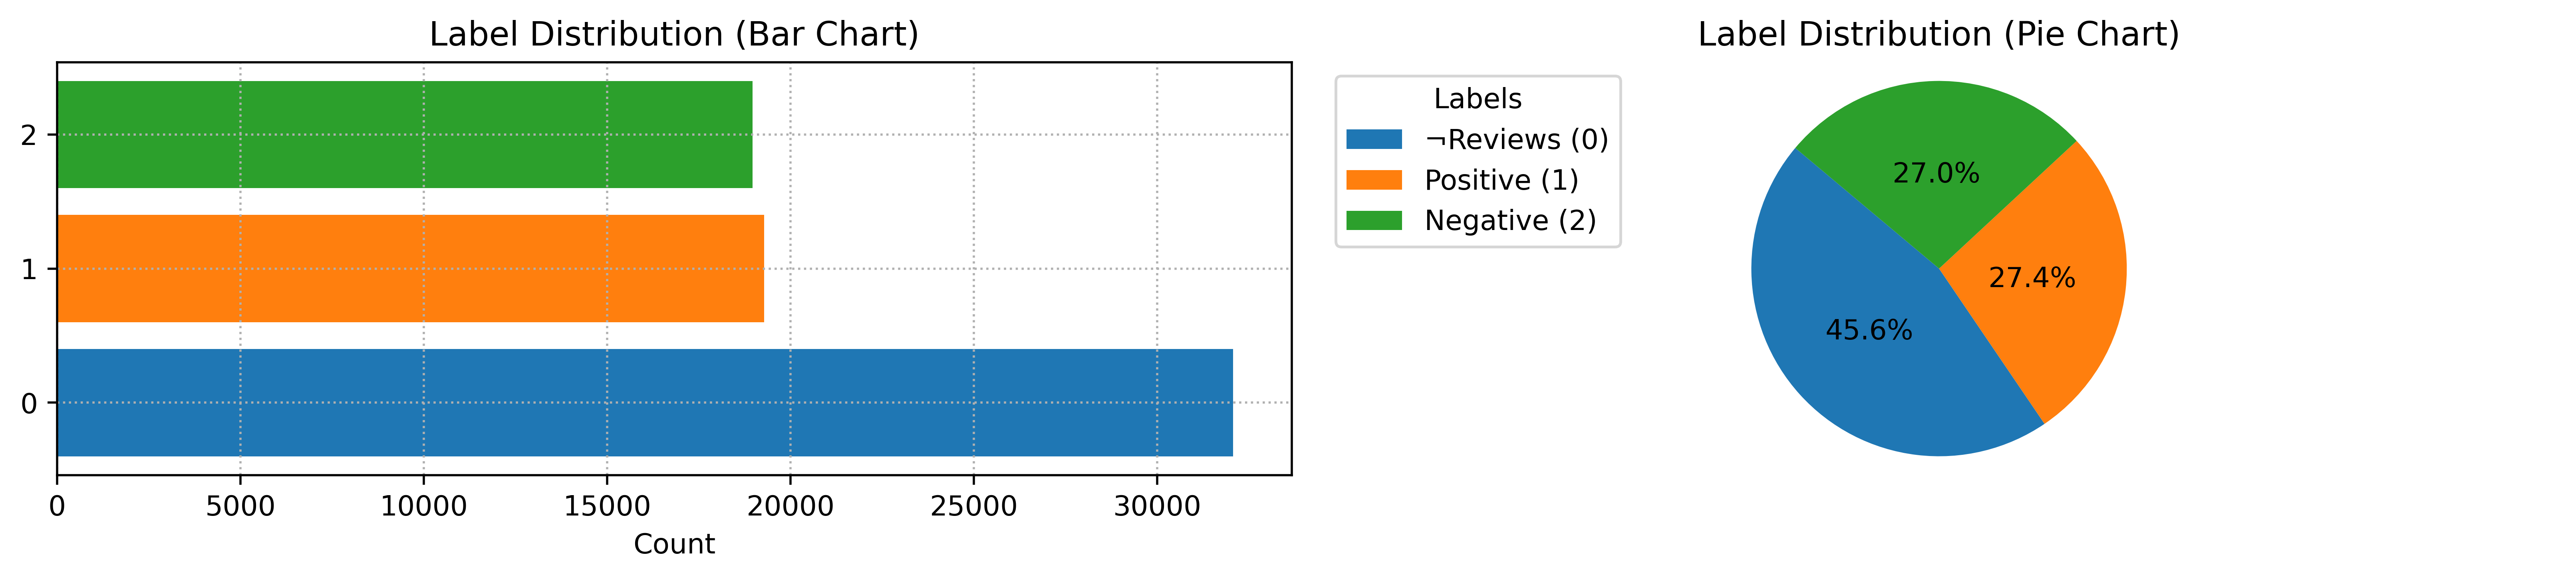

LABEL
0    32065
1    19276
2    18970
Name: count, dtype: int64


In [15]:
# Define figure and subplots
labels = ["¬Reviews (0)","Positive (1)", "Negative (2)"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 3), dpi=500)
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Plotting the bar chart for label distribution
label_counts = df_train['LABEL'].value_counts()
ax1.barh(label_counts.index, label_counts, alpha=1.0,color=colors)
ax1.set_xlabel('Count')
ax1.set_title('Label Distribution (Bar Chart)')
ax1.grid(True, linestyle='dotted')
ax1.set_yticks(np.arange(len(label_counts)))

# Plotting the pie chart for label distribution

ax2.pie(label_counts, autopct='%1.1f%%', pctdistance=0.50,startangle=140,colors=colors)
ax2.set_title('Label Distribution (Pie Chart)')
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax2.legend(labels,
          title='Labels',
          loc='upper left')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
print(df_train['LABEL'].value_counts())

**Notes:** Consider *resampling techniques* to handle the skewed data. &#x2713;

### 2.2 Let's take a deeper look:

In [16]:
# Consider the word count of each review 
df_train['WORD_COUNT'] = df_train['TEXT'].apply(word_tokenize)
df_train['WORD_COUNT'] = df_train['WORD_COUNT'].apply(len)

In [17]:
df_train.head()

,ID,TEXT,LABEL,WORD_COUNT
0,7850790573542594519,If you love good films don't ever buy this pei...,2,14
1,9392069522632994700,The 33 percent of the nations nitwits that sti...,2,233
2,5083704536542443514,I saw Anatomy years ago -- dubbed at a friends...,1,146
3,12418349755186772171,Dark Remains is a home run plain and simple. T...,1,152
4,12144957944004619479,Feh. This movie started out in an interesting ...,2,409


**Notes:** Remember to handle HTML tags &#x2713; , character escape sequences &#x2713;, en dashes &#x2713;, large proportion of non reviews &#x2713;, accents &#x2713;, emoticons &#x2713;, difference languages &#x274c;, etc...

## 3. Preprocessing Data
Convert text to numerical features for a machine learning model.
- TF-IDF is an improvement over the BoW model for penalizing common words (e.g., the) in a document, and boosts terms that appear in a smaller amount of documents. 
- Note: TF-IDF naturally acts as a downboost for stopwords in information retrieval, therefore we will need to supply our own stopword list. Additionally, our documents are reviews and may behave differently than expected when using tf-idf weighting.
- Neither handle certain linguistic features such as negation and sarcasm particularly well—leading to Word2Vec
- Custom lexicons (i.e reviews, movies, and contractions word list)

In [18]:
contractions_path = "../lexicon/contractions.csv"
contractions = pd.read_csv(contractions_path, index_col='Contraction')
contractions_index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

In [19]:
reviews_syn_path = "../lexicon/reviews.csv"
reviews_syn = pd.read_csv(reviews_syn_path, index_col='Word')
reviews_index = reviews_syn.index.str.lower()
reviews_syn.Synonym = reviews_syn.Synonym.str.lower()
reviews_dict = reviews_syn.to_dict()['Synonym']

In [20]:
films_syn_path = "../lexicon/films.csv"
films_syn = pd.read_csv(films_syn_path, index_col='Word')
films_index = films_syn.index.str.lower()
films_syn.Synonym = films_syn.Synonym.str.lower()
films_dict = films_syn.to_dict()['Synonym']

In [21]:
stopwords_path = "../lexicon/stopwords.txt"
with open(stopwords_path, 'r') as file:
    stopwords = file.readlines()
stopwords = [word.rstrip() for word in stopwords] 

In [22]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'does', 'doing', 'a', 'an', 'the', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'how', 'any', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'same', 'so', 'than', 's', 'now', 'and']


### Regular Preprocessing

In [23]:
hyperlink         = r"<a href=.*</a>"
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
lineBreakHTML     = r"<br /><br />?"
lineBreakHTML2    = r"<br />"
dashes            = r"\x86"
unknown_c         = r"\x96"
newline           = r"(\n)+"
nonalphanumeric   = "[^a-z0-9<>]"
money             = r"(£\d{1,3}(,\d{3})*(\.\d+)?)+|(\$\d{1,4}(,\d{4})*(\.\d+)?)+"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"
exclamation       = r"!!+"
ellipsis          = r"\.{2,}"

In [24]:
class TextToFeatures():
    def __init__(self):
        '''
        Initializes an object for converting texts to features
        '''
        self.vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, preprocessor=self.preprocess_text, 
                                          tokenizer=self.nltk_tokenizer, stop_words=stopwords, token_pattern=None, 
                                          ngram_range=(1,3), min_df=4, binary=False, sublinear_tf=True)
#         self.lemmatizer = WordNetLemmatizer()
        
    def nltk_tokenizer(self, document):
        return word_tokenize(document)
        
    def preprocess_text(self, document):
        '''
        Use vaious RegExs to preprocess text.
        
        @param document: text reviews
        @return: processed text
        '''              
        clean_review = document.lower()
        clean_review = re.sub(hyperlink, " <LINK> ", clean_review)
        clean_review = re.sub(urlPattern, " <URL> ", clean_review)
        clean_review = re.sub(lineBreakHTML, " ", clean_review)
        clean_review = re.sub(lineBreakHTML2, " ", clean_review)
        clean_review = re.sub(dashes, " ", clean_review)
        clean_review = re.sub(unknown_c, " ", clean_review)
        clean_review = re.sub(newline, " ", clean_review)
        clean_review = re.sub(money, " ", clean_review)
        clean_review = re.sub(smileemoji, " <positve> ", clean_review)
        clean_review = re.sub(sademoji, " <negative> ", clean_review)
        clean_review = re.sub(neutralemoji, "<neutral> ", clean_review)
        clean_review = re.sub(lolemoji, "<positive> ", clean_review)
        clean_review = re.sub(ellipsis, ' <suspense> ', clean_review)
        clean_review = re.sub(exclamation, ' <intensity> ', clean_review)
        
        # Normalized Phrases 
        clean_review = re.sub(r"can not wait", ' <positive> ', clean_review)
        clean_review = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', ' ', clean_review) # remove emails
        clean_review = re.sub(r'zero( star)? rating', ' <negative> ', clean_review)
        clean_review = re.sub(r'2 thumbs up', ' <positive> ', clean_review)
        clean_review = re.sub(r'high rating', ' <positive> ', clean_review)
        clean_review = re.sub(r'must read', ' <positive> book', clean_review)
        clean_review = re.sub(r'big screen', ' theatre', clean_review)
        clean_review = re.sub(r'(?<=deserves a )zero', ' <negative> ', clean_review)
        clean_review = re.sub(r'sit through', ' watch ', clean_review)
        clean_review = re.sub(r'(?<=on the )screen', ' movies', clean_review)
        clean_review = re.sub(r'movie buff', ' cinephile', clean_review)
        clean_review = re.sub(r'nine out of ten', ' <positive> ', clean_review)
                
        new_text = []        
        for w in clean_review.split():
            if w in films_dict:
                new_text.append(films_dict[w])
            elif w in reviews_dict:
                new_text.append(reviews_dict[w])
            elif w in contractions_dict:
                new_text.append(contractions_dict[w])
            else:
                new_text.append(w)
        processed_review = ' '.join(new_text)  
    
        return processed_review    

    def get_most_common_words(self, texts, num_words=10):
        '''
        Returns a list of the most common words in the given texts along with their frequencies.
        
        @param texts: List of text documents
        @param num_words: Number of most common words to return
        @return: List of tuples containing (word, frequency) pairs
        '''
        words = [word for text in texts for word in self.nltk_tokenizer(self.preprocess_text(text))]
        word_counts = Counter(words)
        
        most_common_words = word_counts.most_common(num_words)
        return most_common_words
           
    def fit(self, training_texts):
        '''
        Fits ("trains") a TextToFeature instance on a collection of documents.
        
        The provided training texts are analyzed to determine the vocabulary, 
        i.e., all feature values that the converter will support. 
        Each such feature value will be associated with a unique integer index 
        that may later be accessed via the .index() method.
        '''
        self.vectorizer.fit(training_texts)
        
    def index(self, feature):
        '''
        Returns the index in the vocabulary of the given feature value.  
        If the features isn't present, return None.

        @param feature: feature
        @return: unique integer index associated with the feature or None if not present.
        '''
        terms = self.vectorizer.vocabulary_
        index = terms.get(feature, None)
        return index
    
    def get_vocab_size(self):
        return len(self.vectorizer.vocabulary_)
    
#     def penn_to_wn(self,tag):
#         if tag.startswith('J'):
#             return wn.ADJ
#         elif tag.startswith('N'):
#             return wn.NOUN
#         elif tag.startswith('R'):
#             return wn.ADV
#         elif tag.startswith('V'):
#             return wn.VERB
#         return None
    
#     def get_sentiment(self,word,tag):
#         wn_tag = self.penn_to_wn(tag)
#         if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
#             return []

#         lemma = self.lemmatizer.lemmatize(word, pos=wn_tag)
#         if not lemma:
#             return []

#         synsets = wn.synsets(word, pos=wn_tag)
#         if not synsets:
#             return []

#         synset = synsets[0]
#         swn_synset = swn.senti_synset(synset.name())
#         return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

#     def calculate_sentiment_score(self, reviews):
#         senti_score = []
#         for review in reviews:
#             pos = neg = 0
#             pos_list = word_tokenize(self.preprocess_text(review))
#             pos_val = nltk.pos_tag(pos_list)
#             senti_val = [self.get_sentiment(x, y) for (x, y) in pos_val]
#             for score in senti_val:
#                 try:
#                     pos += score[1] 
#                     neg += score[2]
#                 except:
#                     continue
#             senti_score.append(pos - neg)

#         return csr_matrix(np.array(senti_score).reshape(-1, 1))

    def transform(self, texts):
        '''
        Creates a feature matrix from a sequence of texts.
        
        @param :
        @return : 
        '''        
        features = self.vectorizer.transform(texts)

        doc_len = np.array([len(text.split()) for text in texts]) 
        doc_len_sparse = csr_matrix(doc_len.reshape(-1, 1)) 
        combined_matrix = hstack([features, doc_len_sparse])
        
        doc_n_sents = np.array([len(sent_tokenize(text)) for text in texts])
        docs_n_sents_sp = csr_matrix(doc_n_sents.reshape(-1,1))
        combined_matrix = hstack([combined_matrix,docs_n_sents_sp])
        
        len_last_sent = np.array([len(sent_tokenize(text)[-1].split()) if text.strip() and sent_tokenize(text) else 0 for text in texts])
        len_sp = csr_matrix(len_last_sent.reshape(-1,1))
        combined_matrix = hstack([combined_matrix,len_sp])
        
#         senti_sp = self.calculate_sentiment_score(texts)
#         combined_matrix = hstack([combined_matrix, senti_sp])
        
        return combined_matrix

## 4. Supervised Machine Learning
Multi-Classification using TF-IDF for Sentiment Analysis.

#### Development Set
> Note: This leaderboard is calculated with approximately 80% of the test data. The final results will be based on the other 20%, so the final standings may be different. Create a development set! 
- After finding a certain F1-score satisfactory, train the entire dataset and then upload to Kaggle!

In [25]:
training_labels = df_train['LABEL']

In [26]:
training_examples = df_train['TEXT']
training_texts = [review for review in training_examples]

In [27]:
X_train, X_dev, y_train, y_dev = train_test_split(training_texts, training_labels, test_size=0.2, random_state=42, stratify=None)

### Logistic Regression with TF-IDF, Bag-of-Words, and etc
- Logistic Regression with TF-IDF, Bag-of-Words (BoW), and Word2Vec

In [28]:
# Calculate class weights
total_samples = len(training_labels)
class_weights = {0: total_samples/(3*32071), 1: total_samples/(3*19276), 2: total_samples/(3*18970)}

In [29]:
# Logistic Regression model
class LRClassifier():
    def __init__(self):
        '''
        Initializes a Logistic Regression classifier. 
        '''
        self.clf = LogisticRegression(penalty='l2', tol=0.0000001, C=100.0, class_weight=class_weights,
                                      random_state=42,solver='liblinear', max_iter=1000, multi_class='auto',
                                      l1_ratio=None)
        
    def train(self, features, labels):
        '''
        Trains the classifier using the given training data (features, y_labels).
        
        @param features: fill later
        @param labels: non-review, positive, negative
        '''
        self.clf.fit(features, labels)
        
    def predict(self, features):
        '''
        Makes predictions for each of the given examples. 
        
        @param features: fill later
        '''
        y_hats = self.clf.predict(features)
        return y_hats

### Model Initialization 
- Initialize classifier
- Dimensions (i.e., number of documents and the size of the vocabulary)
- Report training and prediction time

In [30]:
clf_instance = LRClassifier()

In [31]:
clf = LRClassifier()
clf2 = MultinomialNB()

In [32]:
t2f_instance = TextToFeatures()

In [33]:
# fit vocabulary
start_ts = time.time()
print(f"Fitting the vocabulary...")
to_features = TextToFeatures()
to_features.fit(X_train)
end_ts = time.time()
print(f"Training time [s]: {end_ts-start_ts:.3f}")

Fitting the vocabulary...
Training time [s]: 43.542


In [34]:
# transform into matrix
start_ts = time.time()
print(f"Transforming the vocabulary...")
X = to_features.transform(X_train)
end_ts = time.time()
print(f"Training time [s]: {end_ts-start_ts:.3f}")

Transforming the vocabulary...
Training time [s]: 50.248


In [35]:
num_docs, vocab_size = X.shape
print(f"Number of documents: {num_docs} \nVocabulary Size: {vocab_size}")

Number of documents: 56248 
Vocabulary Size: 314217


### Logistic Regression Classifier

In [36]:
# Train Logistic Regression & get Training Time
start_ts = time.time()
print(f"Training the model...")
clf.train(X, y_train)
end_ts = time.time()
print(f"Training time [s]: {end_ts-start_ts:.3f}")

Training the model...
Training time [s]: 47.370


In [37]:
# Use model to predict & get Prediction Time
start_ts = time.time()
print(f"Making predictions...")
y_pred = clf.predict(to_features.transform(X_dev))
end_ts = time.time()
print(f"Prediction time [s]: {end_ts-start_ts:.3f}")

Making predictions...
Prediction time [s]: 12.641


### Naive Bayes Classifier

In [38]:
# Train Naive Bayes & get Training Time
start_ts = time.time()
print(f"Training the model...")
clf2.fit(X, y_train)
end_ts = time.time()
print(f"Training time [s]: {end_ts-start_ts:.3f}")

Training the model...
Training time [s]: 0.081


In [39]:
# Use model to predict & get Prediction Time
start_ts = time.time()
print(f"Making predictions...")
y_pred2 = clf2.predict(to_features.transform(X_dev))
end_ts = time.time()
print(f"Prediction time [s]: {end_ts-start_ts:.3f}")

Making predictions...
Prediction time [s]: 12.547


## 5. Multi-class Model Evaluation with Confusion Matrix and Classification Report
- Use the classification to evaluate how well the model is
- Identifying the "Not a Movie Review" class is non-trivial
- Improve the discrimination between the Positive and Negative reviews
- Don't forget to test your classifier on a couple outside reviews!

In [40]:
f1score = f1_score(np.array(y_dev), y_pred, average='macro')
print(f"F1 Score: {f1score}")

F1 Score: 0.9276971018550585


In [41]:
report = classification_report(np.array(y_dev), y_pred, labels=[0,1,2])

In [42]:
target_names = ["Not a Movie Review", "Positive Review", "Negative Review"]

In [43]:
print("Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98      6430
           1       0.90      0.89      0.90      3861
           2       0.92      0.90      0.91      3772

    accuracy                           0.94     14063
   macro avg       0.93      0.93      0.93     14063
weighted avg       0.94      0.94      0.94     14063



In [44]:
# confusion matrix!
matrix = confusion_matrix(np.array(y_dev), y_pred, labels = [0, 1, 2])
print("Confusion Matrix: \n", matrix)

Confusion Matrix: 
 [[6320   77   33]
 [ 145 3445  271]
 [  62  301 3409]]


### 5.1 Test your classifier!
- Movie reviews from IMBD for The Boy and the Heron (2023).
- Non-movie review from Amazon for OLLY Fiber Gummy Rings.

In [45]:
# Positive Review test
review = """Seeing The Boy and The Heron, Hayao Miyazaki's latest movie feels almost like a monumental event 
in and of itself. It was announced almost as a surprise with the words "Hayao Miyazaki's last movie". With 
this amount of hype, including the amazing reviews it's got from critics, my hype was built up to the max. 
The end result? Not what I expected, and that's ok!

Let's get to the positives, the animation is STUNNING. The way Hayao Miyazaki manages to build these worlds 
and characters is just an amazing feat, they all come alive with the colours and the movement. Another positive 
is the tone of the movie, I really hate Disney for trying to market this as a kid's movie, when it's not. It's 
got some unnerving and scary moments and themes that are not suited for kids, which is good. Hayao Miyazaki is 
at his best when he manages to blend the adult with the fantastical.

The actors are always amazing, I saw the Japanese dub so I don't know how the western VAs are doing but wow; 
they all do a fantastic job! Now to the negatives... a huge thing about Studio Ghibli movies in general, 
especially the ones from Hayao Miyazaki, is that they're always by rule driven by the characters, it's their 
journey that's in the front. World building and narrative always takes a second place in his movies to be able 
to not distract from the characters journeys, big examples of this are Spirited Away and Howl's Moving Castle 
where the world building is built by very simple and effective means and rules. But here in the Boy and The 
Heron the world building is so convoluted and confusing it almost feels like he wanted it to take center stage 
in this movie and it's such a shame because it feels at like it's at odds with it's own main character who 
supposedly undergoes a deep deep emotional journey but it all finishes off in a very abrupt and unfitting 
send-off in the end which really confused me and just didn't feel like a good payoff.

Also the way this movie introduces characters left and right with no rhyme or reason is super confusing. Once 
again, Hayao Miyazaki did this very minimally in his past movies where the characters get room to be explored 
and to leave an impact in the story but here once again it's at odds with its own world building- it all feels 
very haphazard and messy. The Heron is a fun character but I don't feel like he or Mahito do or learn anything 
from these adventures.

Now, it may sound like I hated this movie, but I didn't. It's just that I care so much about Hayao Miyazaki 
movies and Studio Ghibli movies that I can't help to compare them to the movies we've seen before. And despite 
it not being Hayao Miyazaki's best it's still pretty good, it's very much worth a watch."""

In [46]:
# single_pred = to_features.preprocess_text(review)
print(clf.predict(to_features.transform([review])))

[1]


In [47]:
# Negative Review test
review2 = """
Three of us went to see this movie today (Sat 12/30/23). Preface: we LOVE Ghibli movies (we have 
watched 15+ of them) and have never watched one that we didn't enjoy... until today. First the good: animation 
was fantastic, voice work good, and music was good. But the script. OMG, the plot is a train wreck. The character 
development is nonexistent. Is there clear motivation and a compelling adversary? Nope. The ending was abrupt and 
unsatisfying. I will not spoil anything nor reveal any of the plot, but more WTF plot moments/elements than all 
other Ghibli movies COMBINED. We all rate it worse than Valerian. Two out of tree of us rated this movie THE 
WORST MOVIE WE HAVE EVER SEEN IN A THEATER, no joke! ~~You have been warned~~
"""

In [48]:
# single_pred2 = to_features.preprocess_text(review2)
print(clf.predict(to_features.transform([review2])))

[2]


In [49]:
review3 = """
What a fantastic way to get your fiber in. Tastes like watermelon rings or the sour patch watermelon bites 
but with a sweeter taste to it, not so sour. I love Olly gummy supplements all together:
"""

In [50]:
# single_pred3 = to_features.preprocess_text(review3)
print(clf.predict(to_features.transform([review3])))

[0]


## 5. Kaggle Upload
- Train the classifier over the entire dataset and upload to Kaggle using the correct format.
- Identify the data types for the csv file (uint84, int84).

In [51]:
X_train = training_texts
y_train = training_labels

In [52]:
# Fit & Transform Vocabulary over the entire dataset
start_ts = time.time()
to_features.fit(X_train)
X = to_features.transform(X_train)
end_ts = time.time()
print(f"Training time [s]: {end_ts-start_ts:.3f}")

Training time [s]: 117.628


In [53]:
# Train the final classifier
clf=LRClassifier()
start_ts = time.time()
clf.train(X, y_train)
end_ts = time.time()
print(f"Training time [s]: {end_ts-start_ts:.3f}")

Training time [s]: 65.129


In [54]:
# get the texts from the training data
test_examples = df_test['TEXT']
test_texts = [review for review in test_examples]

# verify the count of training texts
print(f"Length of test texts: {len(test_texts)}")

Length of test texts: 17580


In [55]:
# Make predictions on the test set
start_ts = time.time()
predicted = clf.predict(to_features.transform(test_texts))
id_test = np.array(df_test['ID'])
end_ts = time.time()
print(f"Training time [s]: {end_ts-start_ts:.3f}")

Training time [s]: 15.309


In [56]:
df1 = pd.DataFrame(id_test, columns=['ID'])
df2 = pd.DataFrame(predicted, columns=['LABEL'])

In [57]:
combined_df = pd.concat([df1['ID'], df2['LABEL']], axis=1)
combined_df.dtypes

ID       uint64
LABEL     int64
dtype: object

In [58]:
combined_df.to_csv('test.csv',index=False)

In [59]:
filename = 'test.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(filename)

# Display the first few rows of the DataFrame to verify the data
df.head()
# print(f"Data types: \n {df.dtypes}")

,ID,LABEL
0,4728459160322025755,1
1,1840432070229003467,1
2,12623336783082722606,2
3,7446733850828603409,0
4,16180660281866613068,2


## 6. Pickle

In [60]:
import cloudpickle

In [61]:
filename = 'LogReg_model.pkl'
with open(filename, 'wb') as f:
    cloudpickle.dump(clf, f)

In [62]:
loaded_model = None
with open(filename, 'rb') as f:
    loaded_model = cloudpickle.load(f)

In [63]:
filename = "TfidfVectorizer.pkl"
with open(filename, 'wb') as f:
    cloudpickle.dump(to_features, f)

In [64]:
loaded_vectorizer = None
with open(filename, 'rb') as f:
    loaded_vectorizer = cloudpickle.load(f)

In [65]:
test_input = "This movie sucks!"
result = loaded_vectorizer.transform([test_input])

In [66]:
loaded_model.predict(result)[0]

2